# MonkeyFixationDataset - CenterCrop, binned spike values, no eye data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
import datajoint as dj

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict

from experanto.datasets import ChunkDataset, MonkeyFixation
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader

In [2]:

dj.config['database.host'] = 'at-database3.stanford.edu'
dj.config['database.user'] = ''
dj.config['database.password'] = ''
ephys = dj.create_virtual_module("ephys","ephys")
session_dict = {"session_start_time" :3653578665399, 
                    "paradigm" : "fixation", 
                    "experiment": "CenterSurroundExperiment",
                    #"trial_num": 1, 
                    "files_location":"local",
                    "entire_session" : True,
                    "algorithm" : 'remodnav',
                    "parameter_setting": 'default',
                    'spike_filt_size':101,
                    'spike_filt_sigma':10,
                    'sort_method_num':5,
                    'detect_method_num':6,
                    'spikes_downsample_fs': 100}

[2025-01-12 16:19:33,041][INFO]: Connecting pavi@at-database3.stanford.edu:3306
[2025-01-12 16:19:38,008][INFO]: Connected pavi@at-database3.stanford.edu:3306


In [2]:
from experanto.configs import MONKEY_FIX_OLD as cfg
print(OmegaConf.to_yaml(cfg))

dataset:
  global_sampling_rate: null
  global_chunk_size: null
  modality_config:
    screen:
      keep_nans: false
      sampling_rate: 8.33
      chunk_size: 1
      valid_condition:
        tier: train
        valid_trial: 1
      offset: 0
      sample_stride: 1
      include_blanks: true
      transforms:
        CenterCrop:
          _target_: torchvision.transforms.v2.CenterCrop
          size: 100
        normalization: normalize
      interpolation:
        rescale: true
        rescale_size:
        - 144
        - 256
    responses:
      keep_nans: false
      sampling_rate: 100
      chunk_size: 13
      offset: 0.04
      transforms:
        normalization: null
      interpolation:
        interpolation_mode: nearest_neighbor
    eye_tracker:
      keep_nans: false
      sampling_rate: 8.33
      chunk_size: 1
      offset: 0
      transforms:
        normalization: null
      interpolation:
        interpolation_mode: nearest_neighbor
dataloader:
  batch_size: 32
  shu

In [3]:
paths = ['dynamic-monkeyDataset3744900291863-Video-6','dynamic-monkeyDataset3744900291863-Video-6','dynamic_monkeyDataset3653578665399-Video-3','dynamic-monkeyDataset3638885582960-Video-3'
        ]
full_paths = [path.join("../", f) for f in paths]

In [9]:
dataset = MonkeyFixation(full_paths[0], **cfg.dataset)

../dynamic-monkeyDataset3744900291863-Video-6/responses
../dynamic-monkeyDataset3744900291863-Video-6/screen


In [10]:
dataset[6]

{'responses': tensor([ 3.5423,  2.3821, 11.3147,  8.0627, 11.3046, 13.3522, 14.3898,  8.6001,
         14.7726,  8.7461, 13.0238,  4.3226,  1.8623,  2.3471,  0.0000,  1.0001,
         21.6936,  8.9527,  1.1933,  5.2353, 15.4714,  9.4572,  4.5285, 10.5744,
         16.8927, 22.7133,  8.7455,  4.8914,  4.8029,  6.2592,  3.6320,  5.6563],
        dtype=torch.float64),
 'screen': tensor([[[ 0.3700,  0.1268, -0.1669,  ..., -1.5369, -1.5315, -1.4080],
          [-0.1795,  0.0402,  0.3808,  ..., -1.6683, -1.5985, -1.4841],
          [ 0.0455,  0.3513,  0.5136,  ..., -1.6730, -1.6526, -1.4542],
          ...,
          [ 0.2504, -0.0362, -0.4279,  ..., -0.1910, -0.1510, -0.1420],
          [ 0.1294, -0.2594, -0.4826,  ..., -0.1413, -0.1126, -0.1410],
          [-0.2102, -0.1954, -0.2292,  ..., -0.1477, -0.1401, -0.1474]]],
        dtype=torch.float64),
 'timestamps': tensor([106.3598], dtype=torch.float64)}

In [11]:
len(dataset)

7500

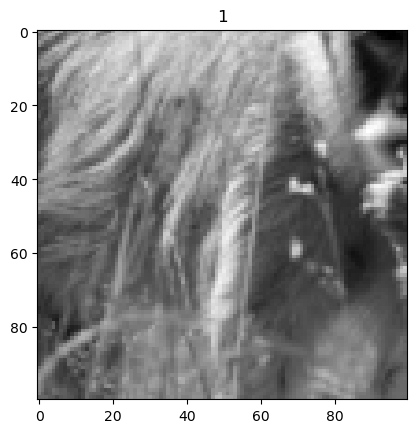

In [12]:
datapoint = dataset[6]
for i in range(len(datapoint["screen"])):
    plt.figure()
    plt.imshow(datapoint["screen"][i], cmap="gray")
    plt.title(f"{i+1}")
    plt.show()

### comparing responses - smoothed spike values in dataset and spike counts in the time window

In [27]:
all_res = []
for i in range(len(dataset)):
    all_res.append(dataset[i]['responses'])
all_res_np = np.stack([t.numpy() for t in all_res])


In [20]:

dj.config['database.host'] = 'at-database3.stanford.edu'
dj.config['database.user'] = 'pavi'
dj.config['database.password'] = 'pavi#1'
ephys = dj.create_virtual_module("ephys","ephys")
csrf = dj.create_virtual_module("george_csrf","george_csrf")
session_dict = {"session_start_time" :3744900291863, 
                    "paradigm" : "fixation", 
                    "experiment": "CenterSurroundExperiment",
                    #"trial_num": 1, 
                    "files_location":"local",
                    "entire_session" : True,
                    "algorithm" : 'remodnav',
                    "parameter_setting": 'default',
                    'spike_filt_size':101,
                    'spike_filt_sigma':10,
                    'sort_method_num':5,
                    'detect_method_num':6,
                    'spikes_downsample_fs': 100}

In [21]:
session_dict['sort_method_num'] = 4
session_dict['detect_method_num'] = 5

In [22]:
binned_counts = (csrf.BinnedSpikes() * csrf.StimulusTrials() & session_dict & {'latency':40,'win_size':120,'trial_type':'Train'}).fetch('binned_counts',order_by='trial_num')
binned_counts_np = np.array([each.sum(axis=1) for each in binned_counts])
binned_counts_np.shape

(7500, 32)

In [23]:
def count_spikes_in_interval(spike_times, start_time, end_time):
    """
    Count the number of spikes for each unit within a given interval.

    Args:
        spike_times: A structured array or list of arrays where each element contains spike times for a unit.
        start_time (float): The start of the interval.
        end_time (float): The end of the interval.

    Returns:
        list: A list of spike counts for each unit.
    """
    spike_counts = []
    
    for unit_spikes in spike_times:
        # Flatten the array for the current unit (in case it's nested)
        unit_spikes = unit_spikes.flatten()
        
        # Count spikes within the interval for the current unit
        count = np.sum((unit_spikes >= start_time*1000) & (unit_spikes < end_time*1000))
        spike_counts.append(count)
    
    return spike_counts

In [24]:
all_counts = []
spike_times = (ephys.Spikes() & session_dict).fetch('spike_times', order_by="unit_id")
for i in range(len(dataset)):
    datapoint = dataset[i]
    all_counts.append(count_spikes_in_interval(spike_times, datapoint['timestamps'].item()+0.04, datapoint['timestamps'].item()+0.04+0.120))
all_counts_np = np.array(all_counts)                                               

### Verifying the binnedspikes in the tables match with the number of spikes we counted manually

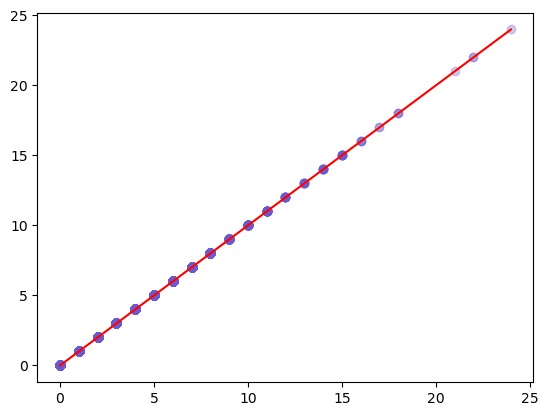

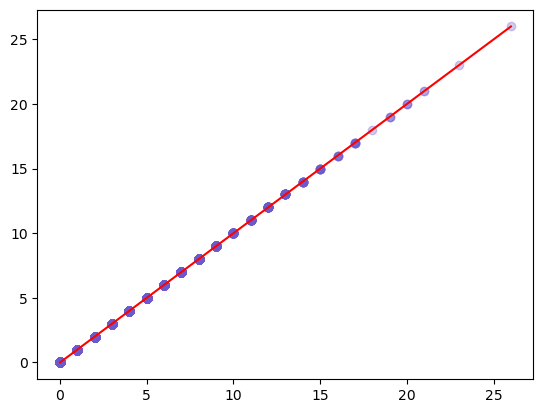

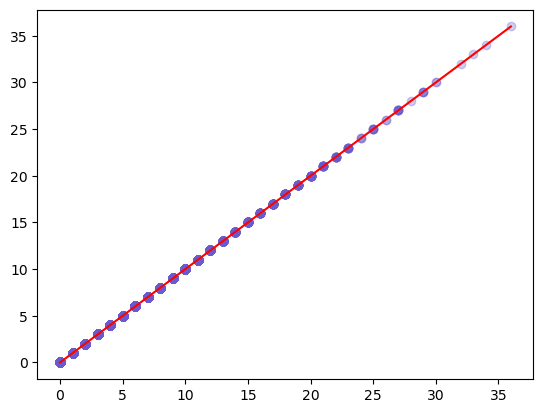

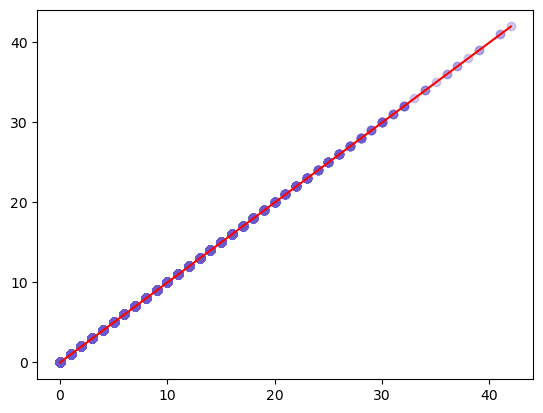

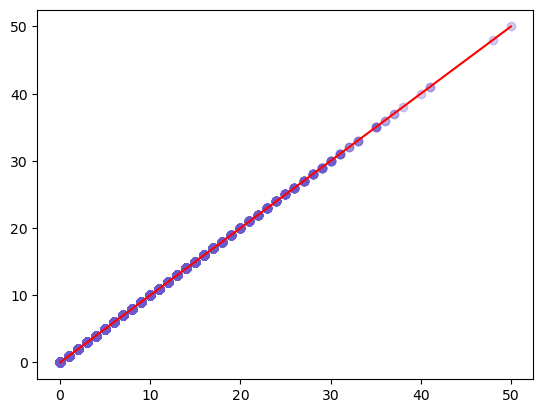

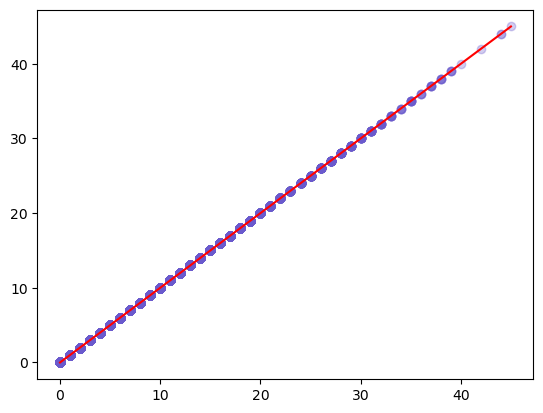

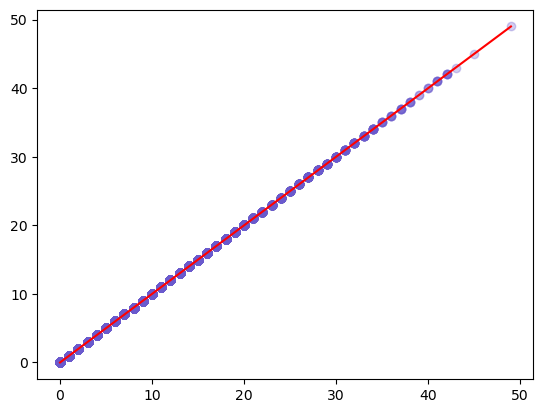

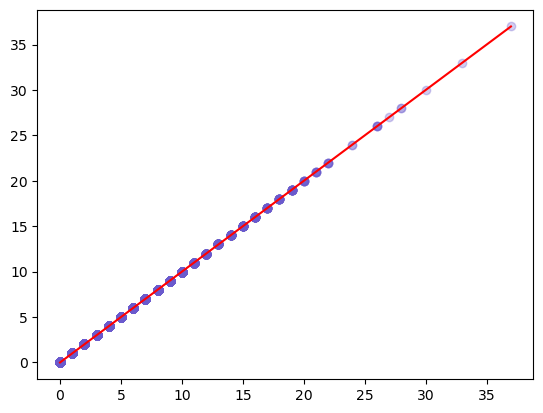

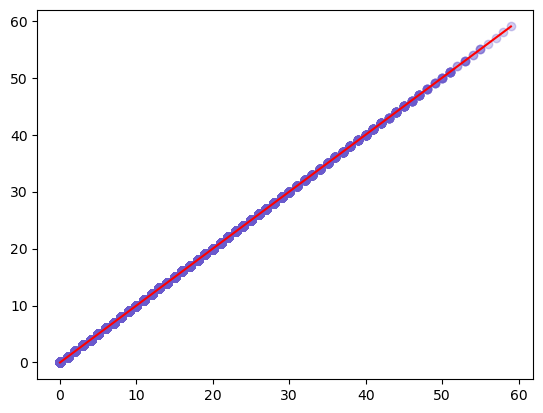

In [25]:
for i in range(9):
    x = np.linspace(0, np.max(all_counts_np.T[i]), 100)
    plt.plot(all_counts_np.T[i], binned_counts_np.T[i],'o',color='slateblue', alpha = 0.3)
    plt.plot(x,x,'r-')
    plt.show()

### Comparing the integrated smoothed spike counts in window with sum of binnedspikes in window

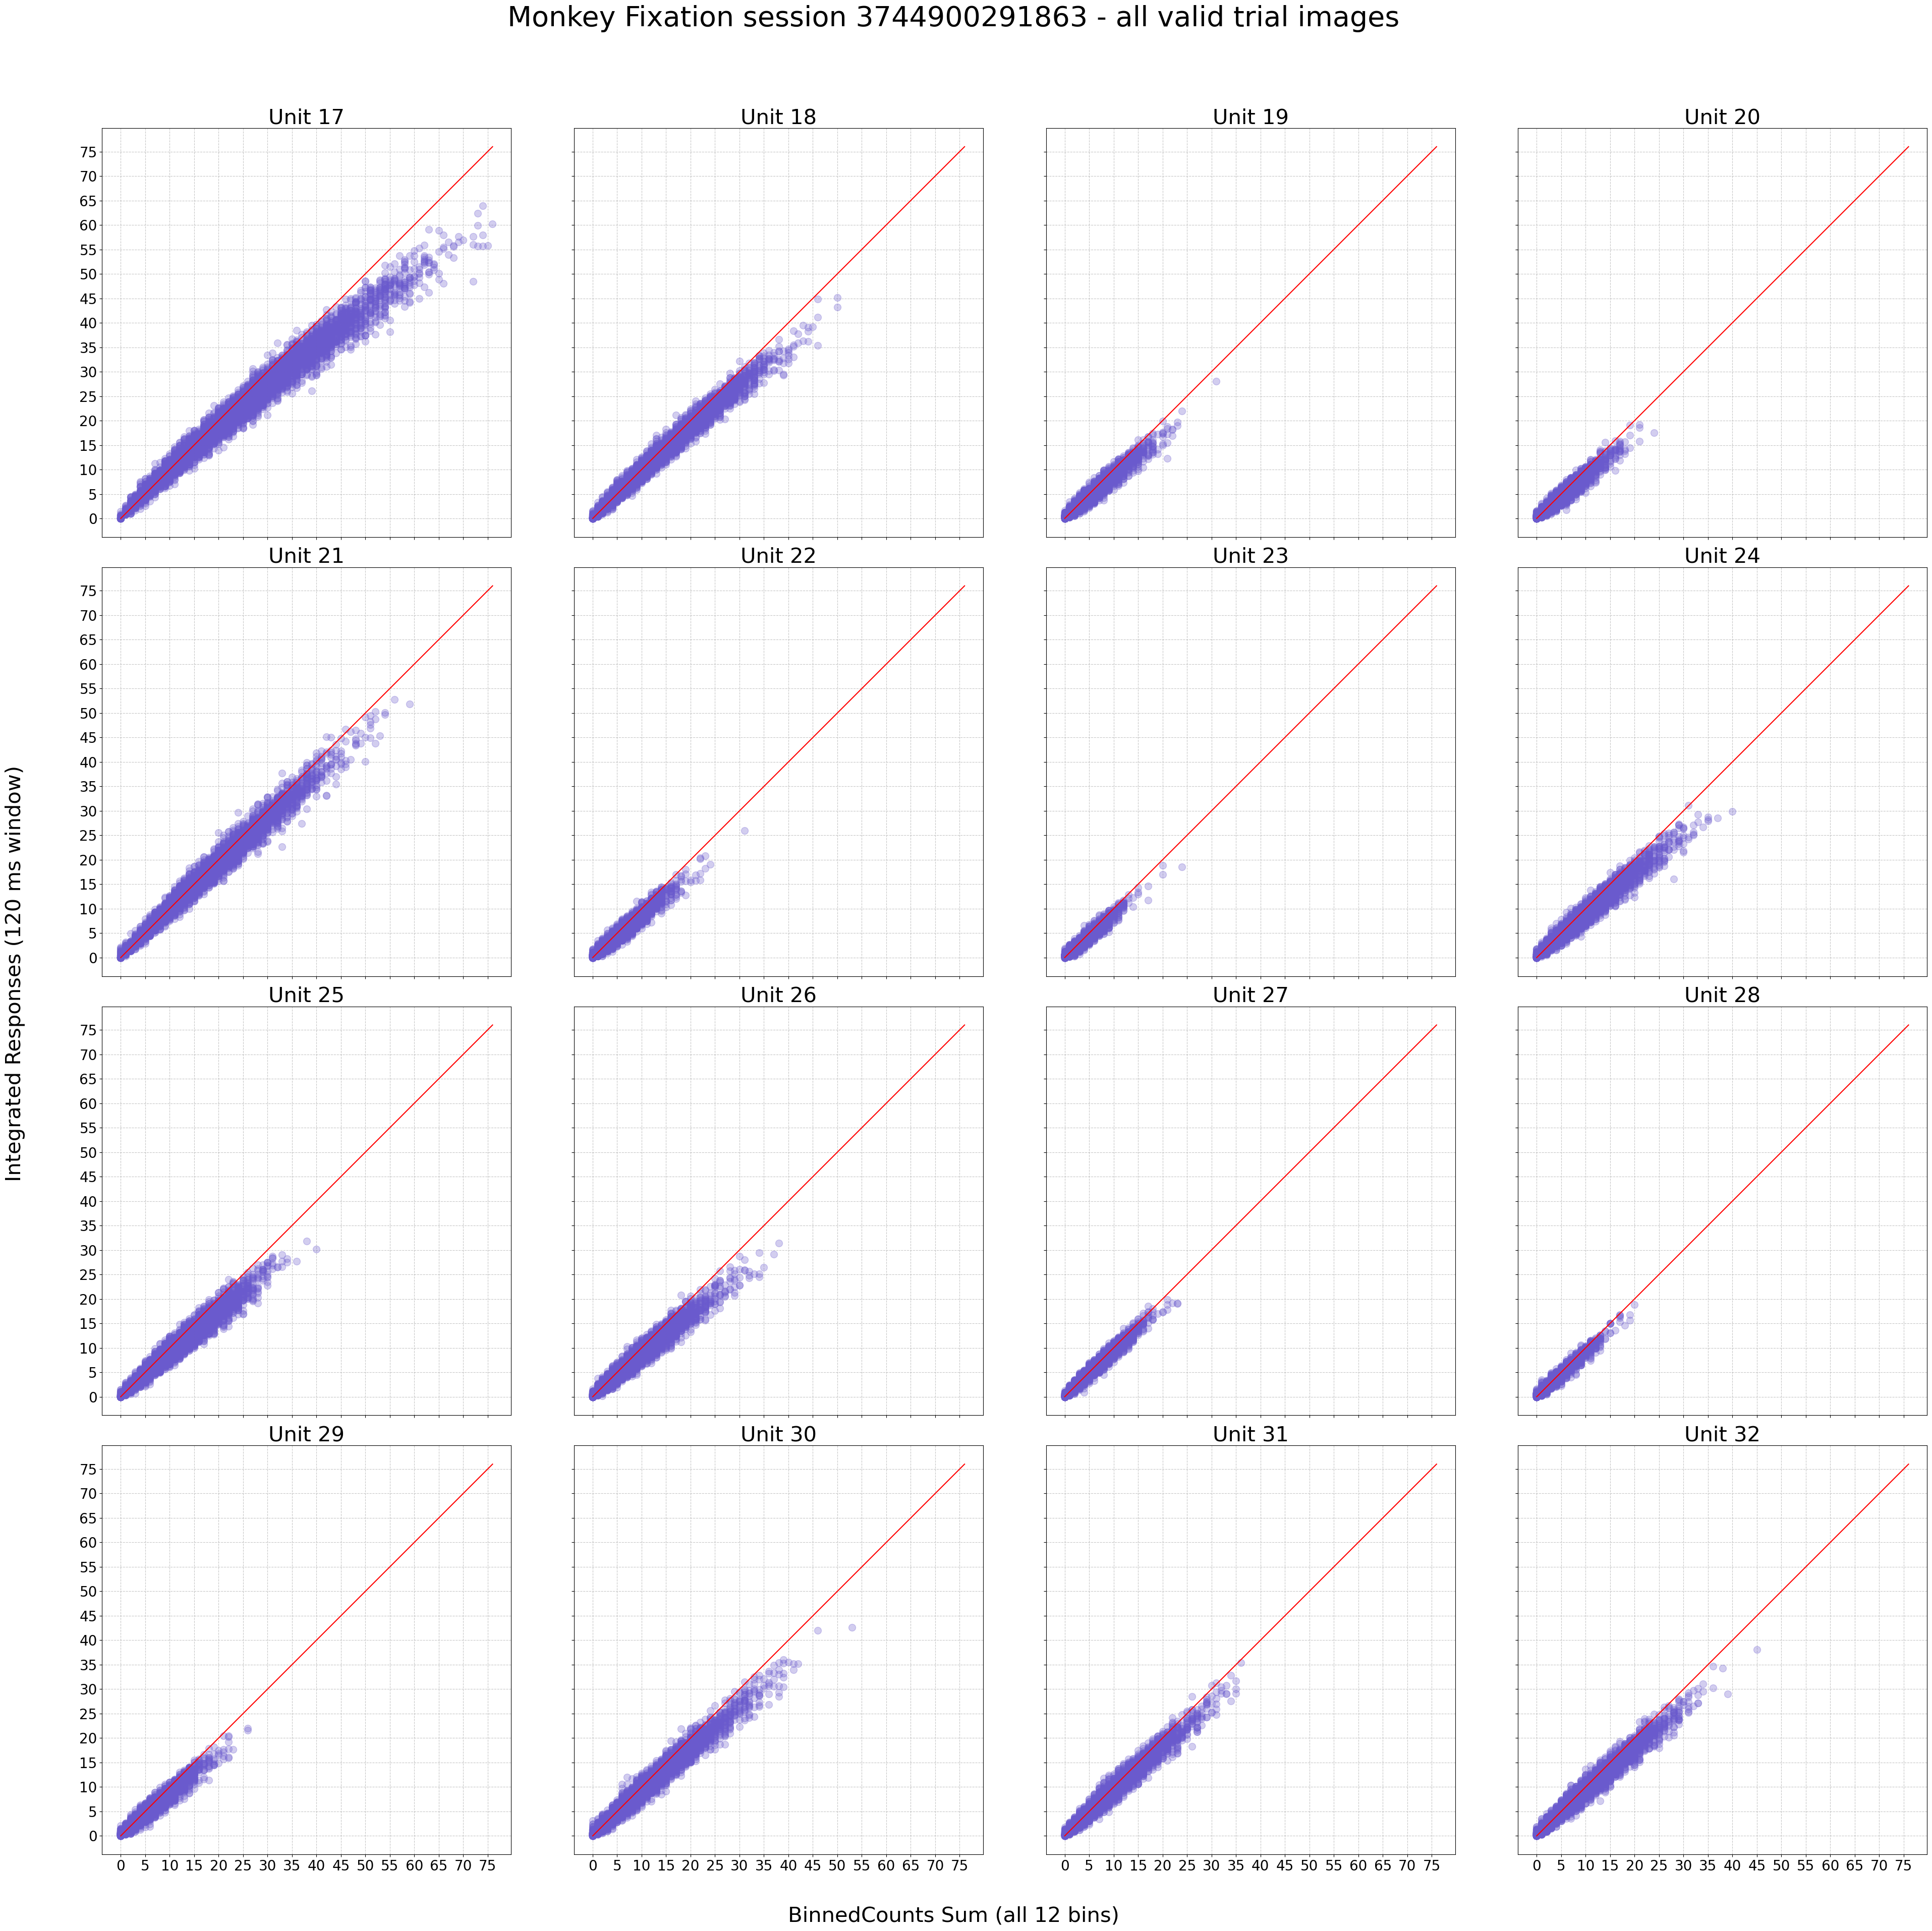

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(40, 40), sharex=True, sharey=True)
x = np.linspace(0, np.max(binned_counts_np.T), int(np.max(binned_counts_np.T)))
tick_range = np.arange(0, np.ceil(np.max(binned_counts_np.T)),step=5)
fig.suptitle("Monkey Fixation session {} - all valid trial images".format(session_dict['session_start_time']), fontsize=40)
# Iterate over each subplot
for i, ax in enumerate(axes.flat):
    #ax.plot(x, y_data[i])  # Plot data in each subplot
    ax.set_title(f"Unit {i+17}",fontsize=30)
    ax.plot(binned_counts_np.T[i+16], all_res_np.T[i+16],'o', color="slateblue",alpha = 0.3, markersize=10)
    ax.plot(x,x,'r-')
    ax.set_aspect('equal')
    ax.set_xticks(tick_range)
    ax.set_yticks(tick_range)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
fig.text(0.5, 0.03, 'BinnedCounts Sum (all 12 bins)', ha='center', fontsize=30)  # X-axis label
fig.text(0.03, 0.5, 'Integrated Responses (120 ms window)', va='center', rotation='vertical', fontsize=30)  # Y-axis label


# Reduce the space between plots and shared labels
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
#fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5, wspace=0.5)

plt.show()
output_file = "Monkey Fixation session {} - all valid trial images-2.png".format(session_dict['session_start_time'])
dpi_value = 300  # High resolution (300 DPI)

# Save the plot
fig.savefig(output_file, dpi=dpi_value, bbox_inches='tight')